In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import time

tempoInicial = time.time()

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, ps, O = 0, L = 1, T = 0.5):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*(w+us)**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    b = np.matmul(matrizB, np.array(ps)) #Multiplicação de arrays já que houve uma conversão anterior
    psi_c = np.linalg.solve(matrizA, b) #Matlab: x = A\b
    #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 2000

    xs = np.linspace(-5, L, M)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.05):
        for j in np.arange(0, 20, 0.01):
            psiExato[r][int(j*100)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, y, psii, psiExato):
    A = multMatrizes(M = 200, us = x[0], ps = psii[0:200, y], O = -5, L = 5, T = 20)
    B = multMatrizes(M = 200, us = x[1], ps = A, O = -5, L = 5, T = 20)
    C = multMatrizes(M = 200, us = x[2], ps = B, O = -5, L = 5, T = 20)
    D = multMatrizes(M = 200, us = x[3], ps = C, O = -5, L = 5, T = 20)
    E = multMatrizes(M = 200, us = x[4], ps = D, O = -5, L = 5, T = 20)
    F = multMatrizes(M = 200, us = x[5], ps = E, O = -5, L = 5, T = 20)
    G = multMatrizes(M = 200, us = x[6], ps = F, O = -5, L = 5, T = 20)
    H = multMatrizes(M = 200, us = x[7], ps = G, O = -5, L = 5, T = 20)
    I = multMatrizes(M = 200, us = x[8], ps = H, O = -5, L = 5, T = 20)
    J = multMatrizes(M = 200, us = x[9], ps = I, O = -5, L = 5, T = 20)
    K = multMatrizes(M = 200, us = x[10], ps = J, O = -5, L = 5, T = 20)
        
    return ((np.linalg.norm(np.array(psiExato[0:200, y])-np.array(psii[0:200, y])))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+1])-np.array(A)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+2])-np.array(B)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+3])-np.array(C)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+4])-np.array(D)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+5])-np.array(E)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+6])-np.array(F)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+7])-np.array(G)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+8])-np.array(H)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+9])-np.array(I)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+10])-np.array(J)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+11])-np.array(K)))**2)

In [6]:
import random

psi = np.zeros((200,2000))
psi_f = np.zeros((200,2000))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 200, O = -5, L = 5, T = 20)
psi_g = CrankNicolson(M = 200, O = -5, L = 5, T = 20)
psiExato = ExactSolution(M = 200)

In [7]:
xs = np.linspace(-5,5,200)

Iteração: 1
Mínimo: -0.3141592653589793
Iteração: 2
Mínimo: -0.3141592653589793
Iteração: 3
Mínimo: -0.3141592653589793
Iteração: 4
Mínimo: -0.3141592653589793
Iteração: 5
Mínimo: -0.3141592653589793
Iteração: 6
Mínimo: -0.3141592653589793
Iteração: 7
Mínimo: -0.3141592653589793
Iteração: 8
Mínimo: -0.3141592653589793
Iteração: 9
Mínimo: -0.3141592653589793
Iteração: 10
Mínimo: -0.3141592653589793
Iteração: 11
Mínimo: -0.31415926535897926
Iteração: 12
Mínimo: -0.31415926535897926
Iteração: 13
Mínimo: -0.31415926535897926
Iteração: 14
Mínimo: -0.31415926535897926
Iteração: 15
Mínimo: -0.31415926535897926
Iteração: 16
Mínimo: -0.31415926535897926
Iteração: 17
Mínimo: -0.31415926535897926
Iteração: 18
Mínimo: -0.3141592653589793
Iteração: 19
Mínimo: -0.3141592653589793
Iteração: 20
Mínimo: -0.3141592653589793
Iteração: 21
Mínimo: -0.3141592653589793
Iteração: 22
Mínimo: -0.3141592653589793
Iteração: 23
Mínimo: -0.3141592653589793
Iteração: 24
Mínimo: -0.3141592653589793
Iteração: 25
Mínim

Iteração: 199
Mínimo: -0.3141592653589793
Iteração: 200
Mínimo: -0.3141592653589793
Iteração: 201
Mínimo: -0.3141592653589793
Iteração: 202
Mínimo: -0.3141592653589793
Iteração: 203
Mínimo: -0.3141592653589793
Iteração: 204
Mínimo: -0.3141592653589793
Iteração: 205
Mínimo: -0.3141592653589793
Iteração: 206
Mínimo: -0.3141592653589793
Iteração: 207
Mínimo: -0.3141592653589793
Iteração: 208
Mínimo: -0.3141592653589793
Iteração: 209
Mínimo: -0.3141592653589793
Iteração: 210
Mínimo: -0.3141592653589793
Iteração: 211
Mínimo: -0.3141592653589793
Iteração: 212
Mínimo: -0.3141592653589793
Iteração: 213
Mínimo: -0.3141592653589793
Iteração: 214
Mínimo: -0.3141592653589793
Iteração: 215
Mínimo: -0.3141592653589793
Iteração: 216
Mínimo: -0.3141592653589793
Iteração: 217
Mínimo: -0.3141592653589793
Iteração: 218
Mínimo: -0.3141592653589793
Iteração: 219
Mínimo: -0.3141592653589793
Iteração: 220
Mínimo: -0.3141592653589793
Iteração: 221
Mínimo: -0.3141592653589793
Iteração: 222
Mínimo: -0.314159265

Iteração: 395
Mínimo: -0.3141592653589793
Iteração: 396
Mínimo: -0.3141592653589793
Iteração: 397
Mínimo: -0.3141592653589793
Iteração: 398
Mínimo: -0.3141592653589793
Iteração: 399
Mínimo: -0.3141592653589793
Iteração: 400
Mínimo: -0.3141592653589793
Iteração: 401
Mínimo: -0.3141592653589793
Iteração: 402
Mínimo: -0.3141592653589793
Iteração: 403
Mínimo: -0.3141592653589793
Iteração: 404
Mínimo: -0.3141592653589793
Iteração: 405
Mínimo: -0.3141592653589793
Iteração: 406
Mínimo: -0.3141592653589793
Iteração: 407
Mínimo: -0.3141592653589793
Iteração: 408
Mínimo: -0.3141592653589793
Iteração: 409
Mínimo: -0.3141592653589793
Iteração: 410
Mínimo: -0.3141592653589793
Iteração: 411
Mínimo: -0.3141592653589793
Iteração: 412
Mínimo: -0.3141592653589793
Iteração: 413
Mínimo: -0.3141592653589793
Iteração: 414
Mínimo: -0.3141592653589793
Iteração: 415
Mínimo: -0.3141592653589793
Iteração: 416
Mínimo: -0.3141592653589793
Iteração: 417
Mínimo: -0.3141592653589793
Iteração: 418
Mínimo: -0.314159265

Iteração: 591
Mínimo: -0.3141592653589793
Iteração: 592
Mínimo: -0.3141592653589793
Iteração: 593
Mínimo: -0.3141592653589793
Iteração: 594
Mínimo: -0.3141592653589793
Iteração: 595
Mínimo: -0.3141592653589793
Iteração: 596
Mínimo: -0.3141592653589793
Iteração: 597
Mínimo: -0.3141592653589793
Iteração: 598
Mínimo: -0.3141592653589793
Iteração: 599
Mínimo: -0.3141592653589793
Iteração: 600
Mínimo: -0.3141592653589793
Iteração: 601
Mínimo: -0.3141592653589793
Iteração: 602
Mínimo: -0.3141592653589793
Iteração: 603
Mínimo: -0.3141592653589793
Iteração: 604
Mínimo: -0.3141592653589793
Iteração: 605
Mínimo: -0.3141592653589793
Iteração: 606
Mínimo: -0.3141592653589793
Iteração: 607
Mínimo: -0.3141592653589793
Iteração: 608
Mínimo: -0.3141592653589793
Iteração: 609
Mínimo: -0.3141592653589793
Iteração: 610
Mínimo: -0.3141592653589793
Iteração: 611
Mínimo: -0.3141592653589793
Iteração: 612
Mínimo: -0.3141592653589793
Iteração: 613
Mínimo: -0.3141592653589793
Iteração: 614
Mínimo: -0.314159265

Iteração: 788
Mínimo: 0.3141592653589792
Iteração: 789
Mínimo: 0.3141592653589792
Iteração: 790
Mínimo: 0.3141592653589792
Iteração: 791
Mínimo: 0.3141592653589792
Iteração: 792
Mínimo: 0.3141592653589792
Iteração: 793
Mínimo: 0.3141592653589792
Iteração: 794
Mínimo: 0.3141592653589792
Iteração: 795
Mínimo: 0.3141592653589792
Iteração: 796
Mínimo: 0.3141592653589792
Iteração: 797
Mínimo: 0.3141592653589792
Iteração: 798
Mínimo: 0.3141592653589792
Iteração: 799
Mínimo: 0.3141592653589792
Iteração: 800
Mínimo: 0.3141592653589792
Iteração: 801
Mínimo: 0.3141592653589792
Iteração: 802
Mínimo: 0.3141592653589792
Iteração: 803
Mínimo: 0.3141592653589792
Iteração: 804
Mínimo: 0.3141592653589792
Iteração: 805
Mínimo: 0.3141592653589792
Iteração: 806
Mínimo: 0.3141592653589792
Iteração: 807
Mínimo: 0.3141592653589792
Iteração: 808
Mínimo: 0.3141592653589792
Iteração: 809
Mínimo: 0.3141592653589792
Iteração: 810
Mínimo: 0.3141592653589792
Iteração: 811
Mínimo: 0.3141592653589792
Iteração: 812
Mí

Iteração: 988
Mínimo: 0.3141592653589792
Iteração: 989
Mínimo: 0.3141592653589792
Iteração: 990
Mínimo: 0.3141592653589792
Iteração: 991
Mínimo: 0.3141592653589792
Iteração: 992
Mínimo: 0.3141592653589792
Iteração: 993
Mínimo: 0.3141592653589792
Iteração: 994
Mínimo: 0.3141592653589792
Iteração: 995
Mínimo: 0.3141592653589792
Iteração: 996
Mínimo: 0.3141592653589792
Iteração: 997
Mínimo: 0.3141592653589792
Iteração: 998
Mínimo: 0.3141592653589792
Iteração: 999
Mínimo: 0.3141592653589792
Iteração: 1000
Mínimo: 0.3141592653589792
Iteração: 1001
Mínimo: 0.3141592653589792
Iteração: 1002
Mínimo: 0.3141592653589792
Iteração: 1003
Mínimo: 0.3141592653589792
Iteração: 1004
Mínimo: 0.3141592653589792
Iteração: 1005
Mínimo: 0.3141592653589792
Iteração: 1006
Mínimo: 0.3141592653589792
Iteração: 1007
Mínimo: 0.3141592653589792
Iteração: 1008
Mínimo: 0.3141592653589792
Iteração: 1009
Mínimo: 0.3141592653589792
Iteração: 1010
Mínimo: 0.3141592653589792
Iteração: 1011
Mínimo: 0.3141592653589792
Iter

Iteração: 1184
Mínimo: 0.3141592653589792
Iteração: 1185
Mínimo: 0.3141592653589792
Iteração: 1186
Mínimo: 0.3141592653589792
Iteração: 1187
Mínimo: 0.3141592653589793
Iteração: 1188
Mínimo: 0.3141592653589793
Iteração: 1189
Mínimo: 0.3141592653589793
Iteração: 1190
Mínimo: 0.3141592653589793
Iteração: 1191
Mínimo: 0.3141592653589793
Iteração: 1192
Mínimo: 0.3141592653589793
Iteração: 1193
Mínimo: 0.3141592653589793
Iteração: 1194
Mínimo: 0.3141592653589793
Iteração: 1195
Mínimo: 0.3141592653589793
Iteração: 1196
Mínimo: 0.03453883390945073
Iteração: 1197
Mínimo: -0.021329946039764774
Iteração: 1198
Mínimo: -0.04346110075414504
Iteração: 1199
Mínimo: -0.09954599745411945
Iteração: 1200
Mínimo: -0.20326364315163858
Iteração: 1201
Mínimo: -0.3141592653589793
Iteração: 1202
Mínimo: -0.3141592653589793
Iteração: 1203
Mínimo: -0.3141592653589793
Iteração: 1204
Mínimo: -0.31415926535897926
Iteração: 1205
Mínimo: -0.31415926535897926
Iteração: 1206
Mínimo: -0.3141592653589793
Iteração: 1207
M

Iteração: 1375
Mínimo: -0.3141592653589793
Iteração: 1376
Mínimo: -0.3141592653589793
Iteração: 1377
Mínimo: -0.3141592653589793
Iteração: 1378
Mínimo: -0.3141592653589793
Iteração: 1379
Mínimo: -0.3141592653589793
Iteração: 1380
Mínimo: -0.3141592653589793
Iteração: 1381
Mínimo: -0.3141592653589793
Iteração: 1382
Mínimo: -0.3141592653589793
Iteração: 1383
Mínimo: -0.3141592653589793
Iteração: 1384
Mínimo: -0.3141592653589793
Iteração: 1385
Mínimo: -0.3141592653589793
Iteração: 1386
Mínimo: -0.3141592653589793
Iteração: 1387
Mínimo: -0.3141592653589793
Iteração: 1388
Mínimo: -0.3141592653589793
Iteração: 1389
Mínimo: -0.3141592653589793
Iteração: 1390
Mínimo: -0.3141592653589793
Iteração: 1391
Mínimo: -0.3141592653589793
Iteração: 1392
Mínimo: -0.3141592653589793
Iteração: 1393
Mínimo: -0.3141592653589793
Iteração: 1394
Mínimo: -0.3141592653589793
Iteração: 1395
Mínimo: -0.3141592653589793
Iteração: 1396
Mínimo: -0.3141592653589793
Iteração: 1397
Mínimo: -0.3141592653589793
Iteração: 1

Iteração: 1566
Mínimo: -0.3141592653589793
Iteração: 1567
Mínimo: -0.3141592653589793
Iteração: 1568
Mínimo: -0.3141592653589793
Iteração: 1569
Mínimo: -0.3141592653589793
Iteração: 1570
Mínimo: -0.3141592653589793
Iteração: 1571
Mínimo: -0.3141592653589793
Iteração: 1572
Mínimo: -0.3141592653589793
Iteração: 1573
Mínimo: -0.3141592653589793
Iteração: 1574
Mínimo: -0.3141592653589793
Iteração: 1575
Mínimo: -0.3141592653589793
Iteração: 1576
Mínimo: -0.3141592653589793
Iteração: 1577
Mínimo: -0.3141592653589793
Iteração: 1578
Mínimo: -0.3141592653589793
Iteração: 1579
Mínimo: -0.3141592653589793
Iteração: 1580
Mínimo: -0.3141592653589793
Iteração: 1581
Mínimo: -0.3141592653589793
Iteração: 1582
Mínimo: -0.3141592653589793
Iteração: 1583
Mínimo: -0.3141592653589793
Iteração: 1584
Mínimo: -0.3141592653589793
Iteração: 1585
Mínimo: -0.3141592653589793
Iteração: 1586
Mínimo: -0.3141592653589793
Iteração: 1587
Mínimo: -0.3141592653589793
Iteração: 1588
Mínimo: -0.3141592653589793
Iteração: 1

Iteração: 1757
Mínimo: -0.3141592653589793
Iteração: 1758
Mínimo: -0.3141592653589793
Iteração: 1759
Mínimo: -0.3141592653589793
Iteração: 1760
Mínimo: -0.3141592653589793
Iteração: 1761
Mínimo: -0.3141592653589793
Iteração: 1762
Mínimo: -0.3141592653589793
Iteração: 1763
Mínimo: -0.3141592653589793
Iteração: 1764
Mínimo: -0.3141592653589793
Iteração: 1765
Mínimo: -0.3141592653589793
Iteração: 1766
Mínimo: -0.3141592653589793
Iteração: 1767
Mínimo: -0.3141592653589793
Iteração: 1768
Mínimo: -0.3141592653589793
Iteração: 1769
Mínimo: -0.3141592653589793
Iteração: 1770
Mínimo: -0.3141592653589793
Iteração: 1771
Mínimo: -0.3141592653589793
Iteração: 1772
Mínimo: -0.3141592653589793
Iteração: 1773
Mínimo: -0.3141592653589793
Iteração: 1774
Mínimo: -0.3141592653589793
Iteração: 1775
Mínimo: -0.3141592653589793
Iteração: 1776
Mínimo: -0.3141592653589793
Iteração: 1777
Mínimo: -0.3141592653589793
Iteração: 1778
Mínimo: -0.3141592653589793
Iteração: 1779
Mínimo: -0.3141592653589793
Iteração: 1

Iteração: 1948
Mínimo: 0.3141592653589793
Iteração: 1949
Mínimo: 0.3141592653589793
Iteração: 1950
Mínimo: 0.3141592653589793
Iteração: 1951
Mínimo: 0.3141592653589793
Iteração: 1952
Mínimo: 0.3141592653589793
Iteração: 1953
Mínimo: 0.3141592653589793
Iteração: 1954
Mínimo: 0.3141592653589793
Iteração: 1955
Mínimo: 0.3141592653589793
Iteração: 1956
Mínimo: 0.3141592653589793
Iteração: 1957
Mínimo: 0.3141592653589793
Iteração: 1958
Mínimo: 0.3141592653589793
Iteração: 1959
Mínimo: 0.3141592653589793
Iteração: 1960
Mínimo: 0.3141592653589793
Iteração: 1961
Mínimo: 0.3141592653589793
Iteração: 1962
Mínimo: 0.3141592653589793
Iteração: 1963
Mínimo: 0.3141592653589793
Iteração: 1964
Mínimo: 0.3141592653589793
Iteração: 1965
Mínimo: 0.3141592653589793
Iteração: 1966
Mínimo: 0.3141592653589793
Iteração: 1967
Mínimo: 0.3141592653589793
Iteração: 1968
Mínimo: 0.3141592653589793
Iteração: 1969
Mínimo: 0.3141592653589793
Iteração: 1970
Mínimo: 0.3141592653589793
Iteração: 1971
Mínimo: 0.314159265

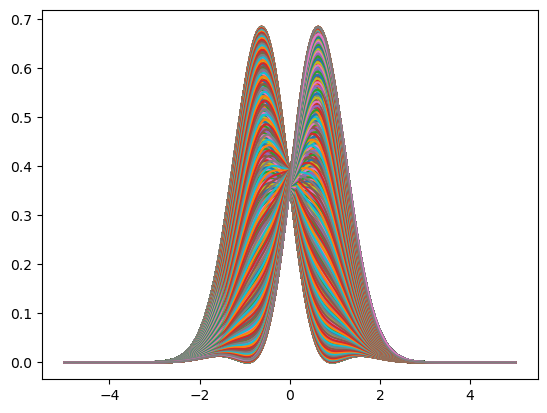

In [8]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,200)
minimo = np.zeros((1, 2000)).astype(complex)
bnds = ((-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi))

while tempo < 1989:
    #print(u1)
    plt.plot(xs, np.absolute(psi[0:200, tempo])**2)
    plt.plot(xs, np.absolute(psi_g[0:200, tempo])**2)
    u2 = optimize.minimize(Objetivo, u1, args=(tempo, psi_g, psiExato), bounds = bnds, method='SLSQP')
    print(f"Iteração: {tempo+1}")
    print(f"Mínimo: {u2.x[0]}")
    #minimo[0][tempo] = (u2.x[0])
    #print("-------------")
    #print(f"{psi[0:200, tempo+1]}")
    if(u2.x[0] > 0):
        psi_g[0:200, tempo+1] = multMatrizes(M = 200, us = u2.x[0], ps = psi_g[0:200, tempo], O = -5, L = 5, T = 20)
    else:
        psi_g[0:200, tempo+1] = multMatrizes(M = 200, us = -u2.x[0], ps = psi_g[0:200, tempo], O = -5, L = 5, T = 20)
    #print("-------------")
    #print(f"{psi[0:200, tempo+1]}")
    tempo += 1
    u1 = []
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])

tempoFinal = time.time() - tempoInicial
print(tempoFinal)

In [9]:
print(psi_g[0:200,1999])
print("---------------")
print(psiExato[0:200,1999])
print("---------------")
print(psi[0:200,1999])
print("--------------")
print(psi_g[0:200,1999] - psi[0:200,1999])
print("--------------")
print(psi_g - psi)

[-3.69227736e-06+9.94341715e-07j -7.06984415e-06+2.93571425e-06j
 -1.01804611e-05+4.00089890e-06j -1.46640563e-05+4.75627697e-06j
 -2.09096709e-05+6.46172640e-06j -2.73125548e-05+8.38367484e-06j
 -3.42674502e-05+1.09906273e-05j -4.36347761e-05+1.39599280e-05j
 -5.60856055e-05+1.67581718e-05j -7.09499769e-05+2.09144109e-05j
 -8.79386022e-05+2.65333413e-05j -1.08343993e-04+3.29518774e-05j
 -1.33647438e-04+4.12370178e-05j -1.64163170e-04+5.02327844e-05j
 -2.01192665e-04+6.01863602e-05j -2.46348898e-04+7.35973248e-05j
 -3.00121546e-04+9.01029109e-05j -3.63755008e-04+1.09325364e-04j
 -4.40158777e-04+1.33247326e-04j -5.32029660e-04+1.61283953e-04j
 -6.40746923e-04+1.94445089e-04j -7.68369667e-04+2.35001391e-04j
 -9.19081904e-04+2.83073636e-04j -1.09705522e-03+3.39330887e-04j
 -1.30587486e-03+4.05704010e-04j -1.55078098e-03+4.83190539e-04j
 -1.83641086e-03+5.74461677e-04j -2.16791622e-03+6.80720421e-04j
 -2.55149334e-03+8.03027701e-04j -2.99329407e-03+9.45041430e-04j
 -3.50121551e-03+1.109423

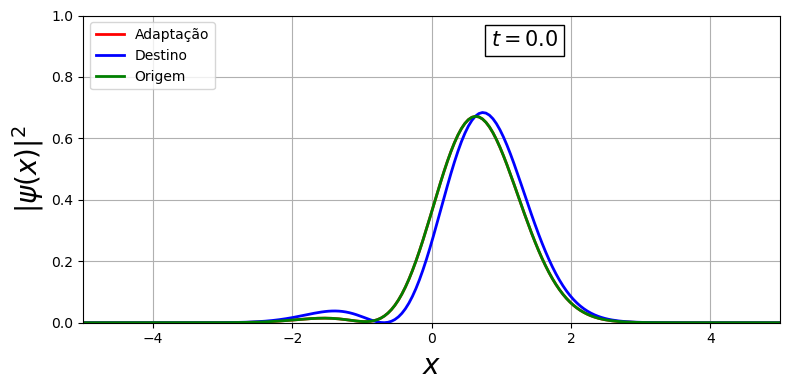

In [10]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,200)
    ln1.set_data(xs, np.absolute(psi_g[0:200,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:200,i-1])**2)
    ln3.set_data(xs, np.absolute(psi[0:200,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Adaptação')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Destino')
ln3, = plt.plot([], [], 'g-', lw=2, markersize=8, label='Origem')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=2000, interval=2000)
ani.save('200x200_bounds.gif',writer='pillow',fps=20,dpi=100)